# Fastai autoencoder

We will see throughout this notebook how to use Fastai autoencoder.

First we import the packages we will need.

In [1]:
from fastai import *
from fastai.vision import *

from fastai_autoencoder.bottleneck import VAEBottleneck
from fastai_autoencoder.callback import VAEHook, HighFrequencyLoss
from fastai_autoencoder.util import *
from fastai_autoencoder.vision.learn import VisionAELearner

from mnist_model import create_decoder, create_encoder_denseblock

This function is a little bit tricky as we want to grab images from MNIST but not all of them as we want to work under little data constraints. Moreover, we also need to keep the rest of the images in a separate Databunch for testing accuracy when we will train a classifier.

In [2]:
def get_data(train_size,bs = 64,size = 28,gray = True):
    # Create two data bunchs, one for training the unsupervised model, one for testing
    # the results of the semi supervised model
    
    # We first load the whole data set 
    path = untar_data(URLs.MNIST)
    tfms = get_transforms(do_flip = False)
    data = (ImageList.from_folder(path/"training")
            .split_none()
            .label_from_folder()
            .transform(tfms,size = size)
            .databunch(bs = bs))

    # We then randomly select train_size samples from the whole MNIST and put in train
    # for the unsupervised, and semi supervised training, and the rest will be used 
    # as a test set for the semi supervised model evaluation
    
    n = len(data.train_ds.x.items)
    
    # We create two data frames which will be used to create the data bunches
    train_idx = np.random.choice(n,train_size,replace = False)
    x_train,y_train = data.train_ds.x.items[train_idx],data.train_ds.y.items[train_idx]
    train_df = pd.DataFrame({"name":x_train,"label":y_train})
    
    valid_idx = np.array(list(set(np.arange(n)) - set(train_idx)))
    x_valid,y_valid = data.train_ds.x.items[valid_idx],data.train_ds.y.items[valid_idx]
    valid_df = pd.DataFrame({"name" : x_valid,"label":y_valid})

    path = Path("/")

    # Data used ofr the training of the autoencoder and classifier
    data = (ImageList.from_df(train_df,path)
            .split_by_rand_pct(seed=42)
            .label_from_df()
            .transform(tfms,size = size)
            .databunch(bs = bs))
    
    # Data used for validation of the classifier
    valid_data = (ImageList.from_df(valid_df,path)
            .split_none()
            .label_from_df()
            .transform(tfms,size = size)
            .databunch(bs = bs))
    
    # We add a transformation to only use one channel since it is in RGB
    def get_one_channel(batch):
        x,y = batch
        return x[:,0,:,:].unsqueeze(1),y
    get_one_channel._order = 99
    
    if gray:
        data.add_tfm(get_one_channel)
        valid_data.add_tfm(get_one_channel)
    
    return data, valid_data

In [3]:
# We create our data bunch
train_size = 512
train_size = int(train_size * 1.25)
bs = 128
size = 28

data, valid_data = get_data(train_size,bs=bs,size=size)

In [4]:
path = untar_data(URLs.MNIST_TINY)
tfms = get_transforms(do_flip = False)

data = (ImageList.from_folder(path)
        .split_by_rand_pct(seed=42)
        .label_from_folder()
        .transform(tfms,size = size)
        .databunch(bs = bs))

def get_one_channel(batch):
    x,y = batch
    return x[:,0,:,:].unsqueeze(1),y

get_one_channel._order = 99

data.add_tfm(get_one_channel)

In [4]:
# Architectural parameters of our model
conv = nn.Conv2d
act_fn = nn.ReLU
bn = nn.BatchNorm2d
rec_loss = "mse"

# Encoder architecture
enc_fn = create_encoder_denseblock
enc_args = {
    "n_dense":3,
    "c_start" :4
}

# Bottleneck architecture
bn_fn = VAEBottleneck
bn_args = {
    "nfs":[128,32]
}

# Decoder architecture
dec_fn = create_decoder
dec_args = {
    "nfs":[32,64,32,16,8,4,2,1],
    "ks":[3,1,3,1,3,1],   
    "size": 28
}

# We create each part of the autoencoder
enc = enc_fn(**enc_args)
bn = bn_fn(**bn_args)
dec = dec_fn(**dec_args)

# We wrap the whole thing in a learner, and add a hook for the KL loss
learn = VisionAELearner(data,rec_loss,enc,bn,dec)
kl_hook = VAEHook(learn,beta=1)

# We add this code to plot the reconstructions
dec_modules = list(learn.dec[1].children())
learn.set_dec_modules(dec_modules)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


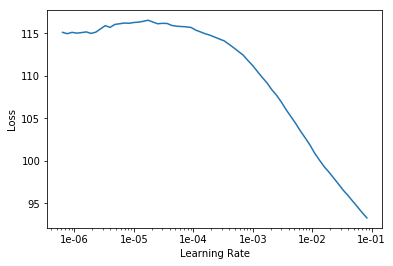

In [5]:
# We search the right learning rate
learn.path = Path()
learn.lr_find()
learn.recorder.plot()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


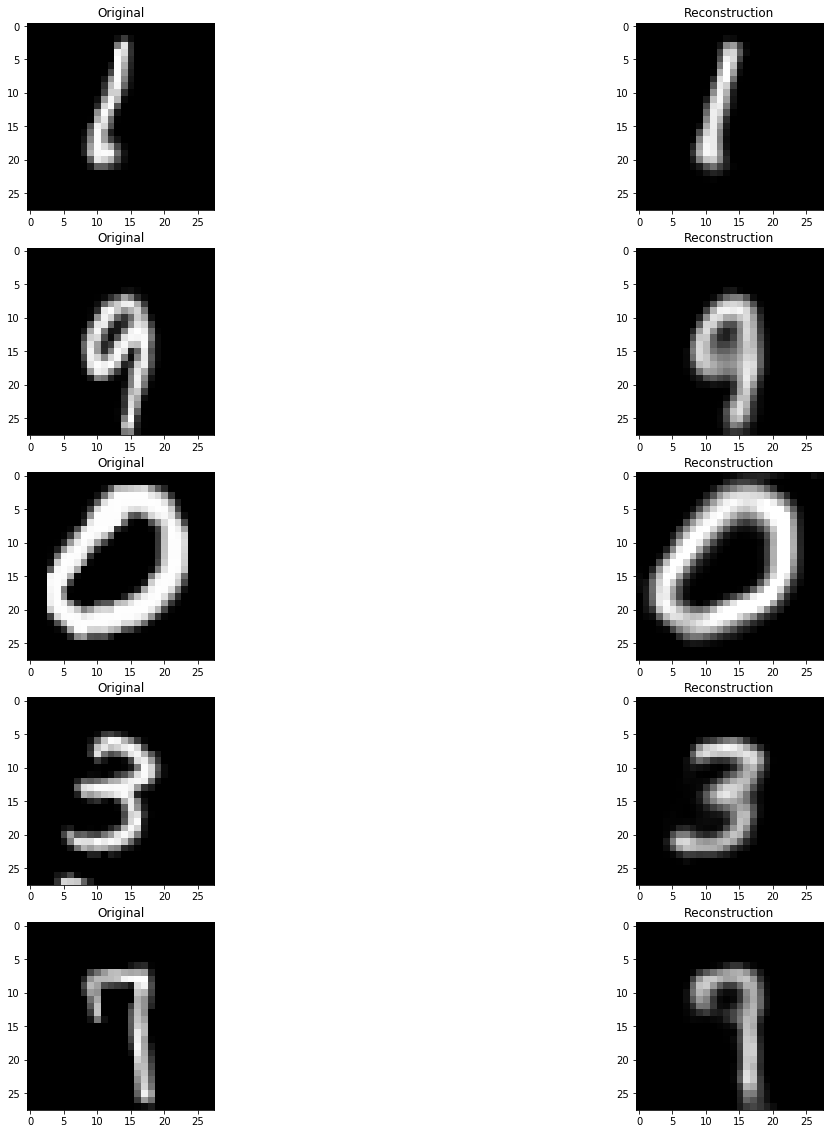

In [54]:
x,y = data.one_batch()
learn.plot_rec(x)

In [5]:
n_epoch = 250
lr = 1e-2

learn.fit_one_cycle(n_epoch,lr)

n_epoch = 250
lr = 1e-2 / 2
cbs = [kl_hook]

learn.fit_one_cycle(n_epoch,lr,callbacks=cbs)

epoch,train_loss,valid_loss,time
0,69.879387,82.199051,00:01
1,70.452164,79.155426,00:00
2,70.206955,76.858841,00:00
3,70.046532,75.286484,00:00
4,69.935158,74.242325,00:00
5,69.483200,73.602173,00:00
6,69.039993,73.246262,00:00
7,68.554504,72.972900,00:00
8,68.098221,72.534348,00:00
9,67.658386,71.637337,00:00


epoch,train_loss,valid_loss,time
0,9.600689,12.137428,00:00
1,9.657393,12.196969,00:00
2,9.637343,12.400789,00:00
3,9.544830,12.453858,00:00
4,9.483262,12.471482,00:00
5,9.435926,12.475458,00:00
6,9.422851,12.464951,00:00
7,9.389390,12.676283,00:00
8,9.390201,12.651520,00:00
9,9.449460,12.906330,00:00


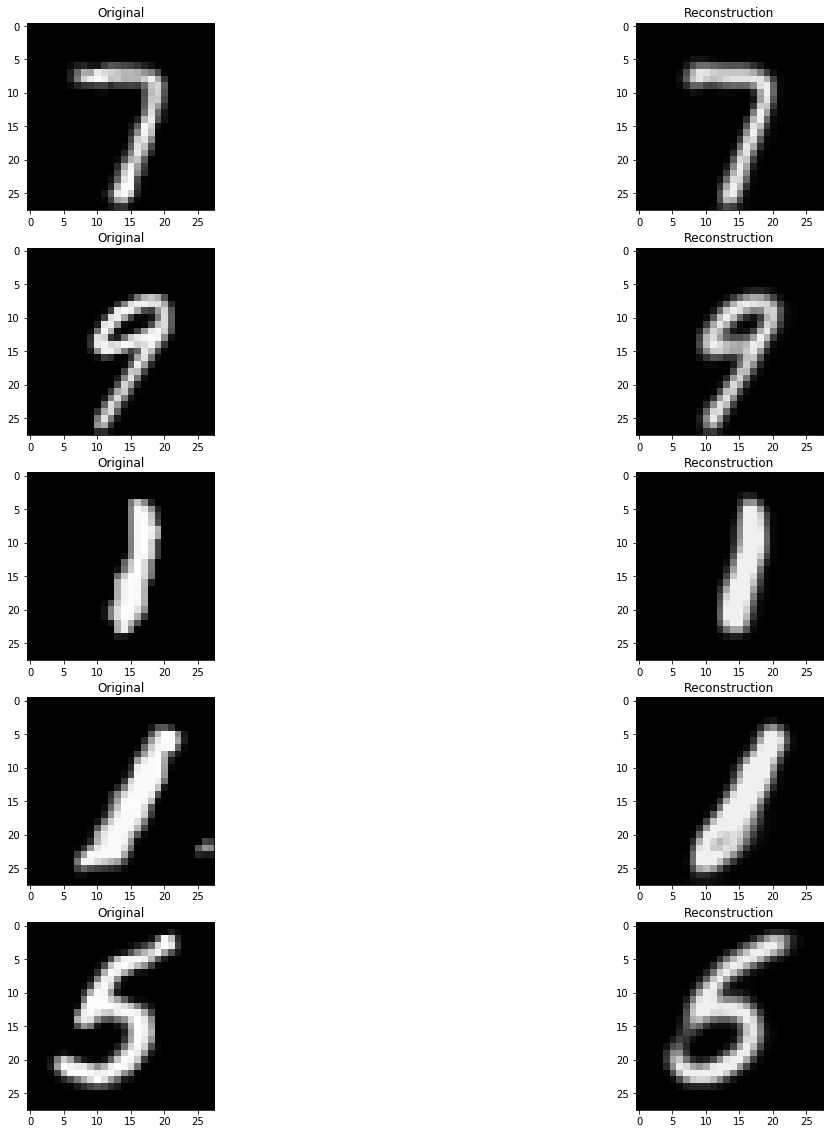

In [22]:
learn.plot_rec(x)

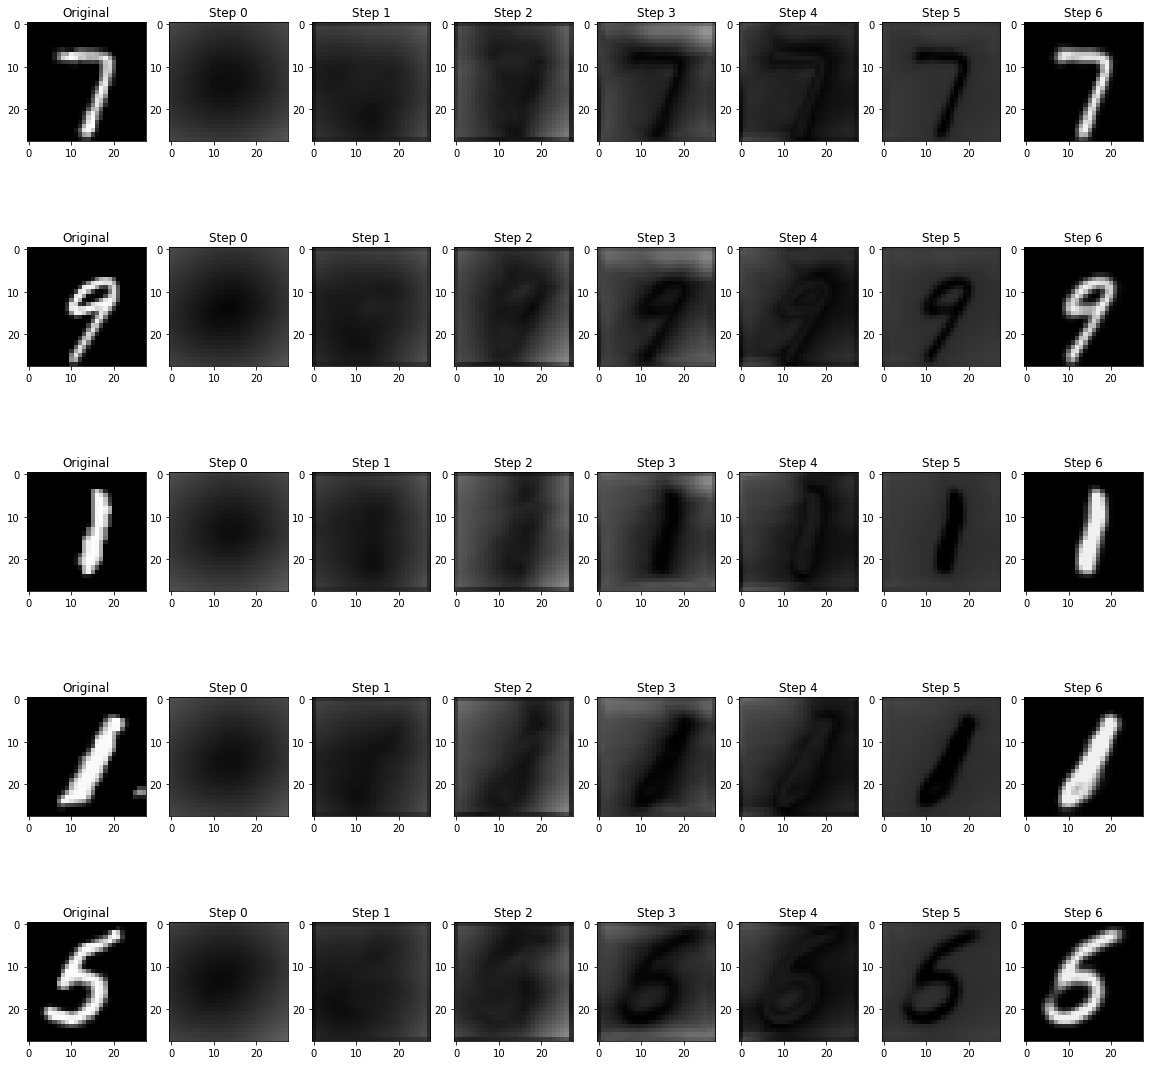

In [23]:
learn.plot_rec_steps(x)

Computing the TSNE projection


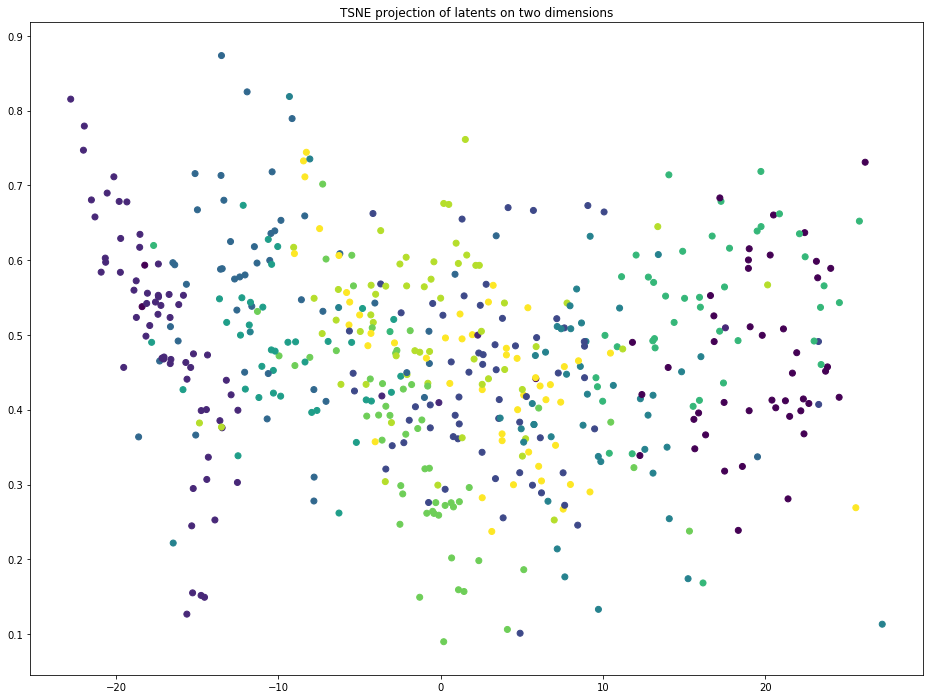

In [6]:
learn.plot_2d_latents(DatasetType.Train)

In [7]:
# We save our model
learn.path = Path()
learn.save("model")

In [8]:
# We load our model
learn.path = Path()
learn.load("model")

VisionAELearner(data=ImageDataBunch;

Train: LabelList (512 items)
x: ImageList
Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28)
y: CategoryList
4,4,3,4,7
Path: /;

Valid: LabelList (128 items)
x: ImageList
Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28)
y: CategoryList
6,5,0,1,0
Path: /;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): ConvBnRelu(
        (conv): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act_fn): ReLU(inplace)
      )
      (1): ResBlock(
        (conv1): ConvBnRelu(
          (conv): Conv2d(4, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act_fn): ReLU(inplace)
        )
        (conv2): ConvBnRe

In [6]:
# We grab some data and download a pretrained model
data,valid_data = get_data(512,bs = bs,gray=False)
clf = cnn_learner(data, models.resnet18, metrics=accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


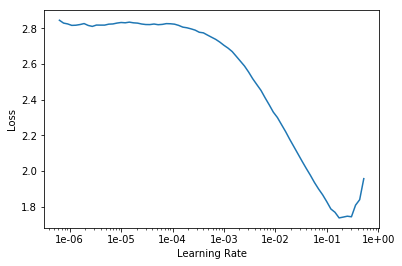

In [7]:
clf.path = Path()
clf.lr_find()
clf.recorder.plot()

In [10]:
# Here we train a pretrained Resnet18 with different training data sizes
n_batchs = [1,2,4]
bs = 128

output = []

for n_batch in n_batchs:
    ds = int(n_batch * bs * 1.25)
    data,valid_data = get_data(ds,bs = bs,gray=False)
    clf = cnn_learner(data, models.resnet18, metrics=accuracy)
    clf.fit_one_cycle(100,1e-2)
    
    clf.data = valid_data
    pred,y = clf.get_preds(DatasetType.Train)
    score = (pred.argmax(dim=1) == y).float().mean().item()
    
    row = {"ds":n_batch * bs,"score":score,"model":"resnet18"}
    output.append(row)

In [11]:
# We create the training data sets for the semi supervised classifier
n_batchs = [1,2,4]
bs = 128

datasets = []
for n_batch in n_batchs:
    ds = int(n_batch * bs * 1.25)
    data,valid_data = get_data(ds,bs = bs)
    datasets.append((data,valid_data))

In [12]:
# We freeze weights of the encoder
def freeze_model(model):
    model.eval()
    for params in model.parameters():
        params.requires_grad = False


# We train our model
for data,valid_data in datasets:
    ds = len(data.train_ds.x.items)
    
    learn.load("model")    
    freeze_model(learn.encode)

    lin = nn.Sequential(nn.Linear(32,16),nn.BatchNorm1d(16),nn.ReLU(inplace=True),nn.Linear(16,10))
    layers = [learn.encode,lin]
    clf_model = nn.Sequential(*layers)

    clf = Learner(learn.data,clf_model,metrics=accuracy)
    
    lr = 1e-2
    clf.fit_one_cycle(100,lr)

    clf.data = valid_data
    clf.data.batch_size = 4096

    pred,y = clf.get_preds(DatasetType.Train)
    score = (pred.argmax(dim=1) == y).float().mean().item()
    
    row = {"ds":ds,"score":score,"model":"pretrained"}
    output.append(row)

model
pretrained    AxesSubplot(0.125,0.125;0.775x0.755)
resnet18      AxesSubplot(0.125,0.125;0.775x0.755)
Name: score, dtype: object

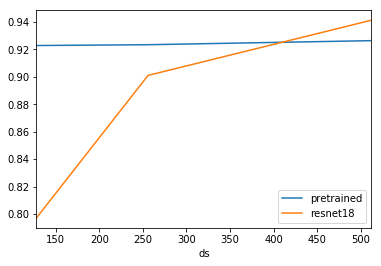

In [23]:
import seaborn as sns

df = pd.DataFrame(output)

df.set_index("ds").groupby("model")["score"].plot(legend=True)